# T-Maze Inference for Planning with BFE

In [1]:
using LinearAlgebra
using ForneyLab
using Plots

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

# Model

In [2]:
T = 2

fg = FactorGraph()

u = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV x_t_min ~ Categorical(placeholder(:D_t_min, dims=(8,)))

x_k_min = x_t_min
for k=1:T
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k],id=:x_*k)

    placeholder(u[k], :u, index=k, dims=(8,8))
    @RV y[k] ~ Transition(x[k], placeholder(:A, dims=(16,8), var_id=:A_*k))
    Categorical(y[k], placeholder(:C, dims=(16,), index=k, var_id=:C_*k))
    
    x_k_min = x[k]
end
;

In [3]:
q = PosteriorFactorization(fg)
algo = messagePassingAlgorithm(x_t_min, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code))
;

In [4]:
println(code)

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 14))

messages[1] = ruleSPCategoricalOutNP(nothing, Message(Multivariate, PointMass, m=data[:C][1]))
messages[2] = ruleSPTransitionIn1CNP(messages[1], nothing, Message(MatrixVariate, PointMass, m=data[:A]))
messages[3] = ruleSPCategoricalOutNP(nothing, Message(Multivariate, PointMass, m=data[:D_t_min]))
messages[4] = ruleSPTransitionOutNCP(nothing, messages[3], Message(MatrixVariate, PointMass, m=data[:u][1]))
messages[5] = ruleSPEqualityCategorical(messages[4], messages[2], nothing)
messages[6] = ruleSPTransitionOutNCP(nothing, messages[5], Message(MatrixVariate, PointMass, m=data[:u][2]))
messages[7] = ruleSPTransitionOutNCP(nothing, messages[6], Message(MatrixVariate, PointMass, m=data[:A]))
messages[8] = ruleSPCategoricalOutNP(nothing, Message(Multivariate, PointMass, m=data[:C][2]))
messages[9] = ruleSPTransitionIn1CNP(messages[8], nothing, Message(MatrixVariate, PointMass, m=

# Results

In [5]:
# Reward probability and utility, uncomment scenario of interest
α = 0.9; c = 2.0

include("environment.jl")
include("agent.jl")
include("helpers.jl")

(A, B, C, D) = constructABCD(α, c)
C_t = [ones(16)./16, C] # Goal prior
;

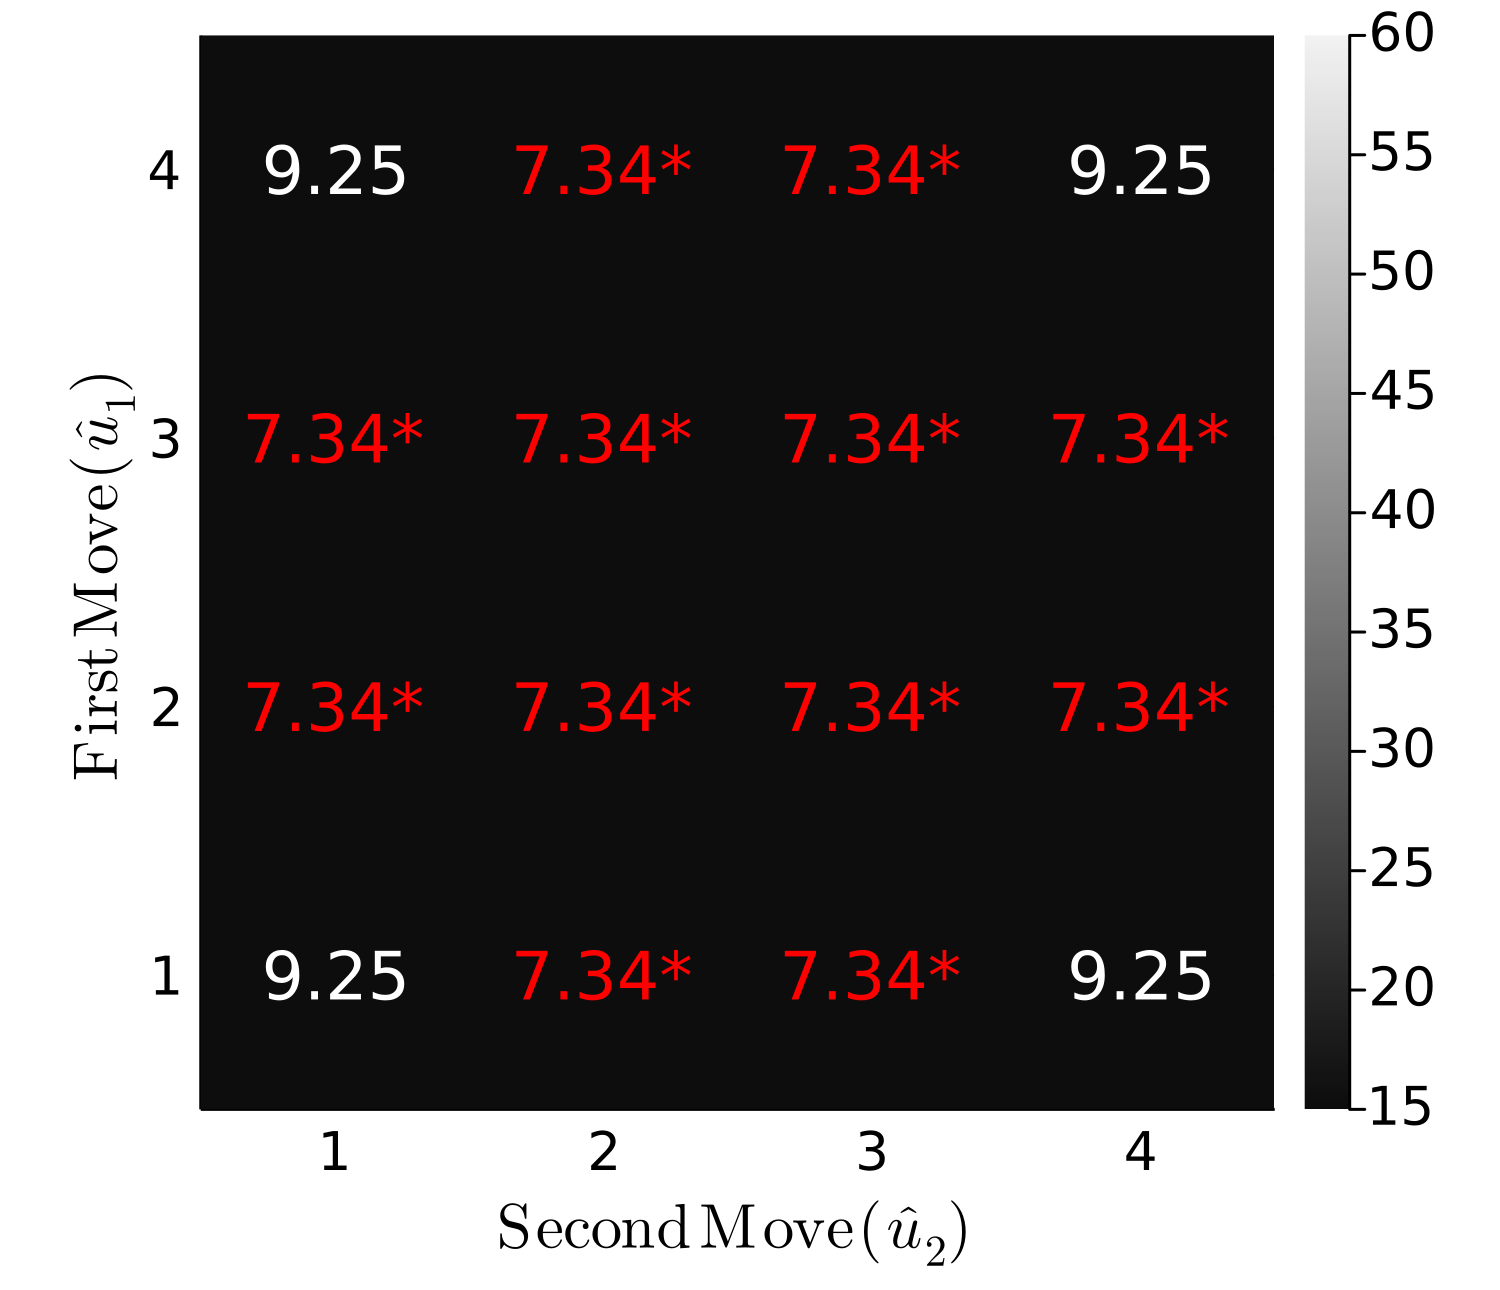

In [6]:
# GBFE for all policies
BFE = evaluatePoliciesBFE(A, B, C_t, D)
plotResults(BFE, clim=(15.0,60.0), dpi=300, highlight=minimum)
#savefig("BFE_c_$(c)_a_$(α).png")